### Import libraries and data

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
)
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/unique_outages2.csv', parse_dates=['Start', 'Finish', 'file_name'])
df['Duration_Category'].value_counts()

Duration_Category
11.0–14.0 hrs    649
20.8+ hrs        558
9.5–11.0 hrs     525
2.8–9.5 hrs      395
0–2.8 hrs        114
14.0–20.8 hrs     30
Name: count, dtype: int64

### Function for model training and evaluation

In [8]:
from sklearn.model_selection import GridSearchCV


def train_and_evaluate_rf(df, train_model=True, model=None, test_size=0.2, random_state=42, fine_tune=False):
    # --- 1. Select Features and Target
    features = ['Recall_Day_Hours', 'Recall_Night_Hours', # numerical columns
                'Project Work?', 'DNSP Aware?', 'Generator Aware?', 'Inter-Regional', # boolean columns
                'Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description' # categorical coumns
                ] 
    target = 'Duration_Category'

    X = df[features].copy()
    y = df[target]

    # --- 2. Encode Categorical Features
    for col in ['Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description']:
        X[col] = LabelEncoder().fit_transform(X[col])

    # --- 3. Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # --- 4. Train Model (if needed)
    if train_model or model is None:
        model = RandomForestClassifier(random_state=random_state)
        
        if fine_tune:
            # --- Fine-tuning with GridSearchCV
            param_grid = {
                'n_estimators': [50, 100, 150],  # Number of trees in the forest
                'max_depth': [None, 10, 20, 30],  # Depth of the trees
                'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
                'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
                'bootstrap': [True, False]  # Whether bootstrap samples are used
            }

            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                                       cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
            grid_search.fit(X_train, y_train)

            # Get the best model from grid search
            model = grid_search.best_estimator_
            print("Best Hyperparameters:", grid_search.best_params_)

        else:
            # If no fine-tuning, just train the model as usual
            model.fit(X_train, y_train)

    # --- 5. Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # --- 6. Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # --- 7. Get present labels (classes that actually exist)
    full_label_order = [
        '0–2.8 hrs',
        '2.8–9.5 hrs',
        '9.5–11.0 hrs',
        '11.0–14.0 hrs',
        '14.0–20.8 hrs',
        '20.8+ hrs'
    ]
    present_labels = [label for label in full_label_order if label in y_test.unique()]

    # --- 8. Classification Report
    print("Classification Report (Test Set):")
    print(classification_report(y_test, y_test_pred, labels=present_labels, target_names=present_labels))

    # --- 9. Visualization (same as before)
    import matplotlib.gridspec as gridspec

    fig = plt.figure(figsize=(18, 16))
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1]) 

    # --- Feature Importances
    ax0 = fig.add_subplot(gs[0, :])
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = X.columns

    ax0.barh(np.array(feature_names)[indices], importances[indices], color='goldenrod')
    ax0.invert_yaxis()
    ax0.set_title("Feature Importances")
    ax0.set_xlabel("Importance")

    # --- Confusion Matrices
    cm_train = confusion_matrix(y_train, y_train_pred, labels=present_labels)
    cm_test = confusion_matrix(y_test, y_test_pred, labels=present_labels)

    ax1 = fig.add_subplot(gs[1, 0])
    disp_train = ConfusionMatrixDisplay(cm_train, display_labels=present_labels)
    disp_train.plot(ax=ax1, cmap='viridis', xticks_rotation=45, values_format='d', colorbar=False)
    ax1.set_title(f"Train Confusion Matrix\n(Acc: {train_acc:.2%})")

    ax2 = fig.add_subplot(gs[1, 1])
    disp_test = ConfusionMatrixDisplay(cm_test, display_labels=present_labels)
    disp_test.plot(ax=ax2, cmap='viridis', xticks_rotation=45, values_format='d', colorbar=False)
    ax2.set_title(f"Test Confusion Matrix\n(Acc: {test_acc:.2%})")

    # --- Duration Category Distributions
    # Dynamically detect available categories in training/testing sets
    train_categories = y_train.value_counts().sort_index()
    test_categories = y_test.value_counts().sort_index()

    # Sort by full_label_order if available
    train_counts = train_categories.reindex([label for label in full_label_order if label in train_categories.index])
    test_counts = test_categories.reindex([label for label in full_label_order if label in test_categories.index])

    ax3 = fig.add_subplot(gs[2, 0])
    ax3.bar(train_counts.index, train_counts.values, color='darkcyan')
    ax3.set_title("Train Set Duration Category Distribution")
    ax3.set_xlabel("Duration Category")
    ax3.set_ylabel("Count")
    ax3.tick_params(axis='x', rotation=45)

    ax4 = fig.add_subplot(gs[2, 1])
    ax4.bar(test_counts.index, test_counts.values, color='slateblue')
    ax4.set_title("Test Set Duration Category Distribution")
    ax4.set_xlabel("Duration Category")
    ax4.set_ylabel("Count")
    ax4.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return model  # Return model for possible reuse

### Model fitting on all data

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Hyperparameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.73      0.52      0.61        21
  2.8–9.5 hrs       0.85      0.67      0.75        83
 9.5–11.0 hrs       0.59      0.75      0.66       106
11.0–14.0 hrs       0.76      0.73      0.74       126
14.0–20.8 hrs       1.00      0.20      0.33         5
    20.8+ hrs       0.84      0.86      0.85       114

     accuracy                           0.74       455
    macro avg       0.80      0.62      0.66       455
 weighted avg       0.76      0.74      0.74       455



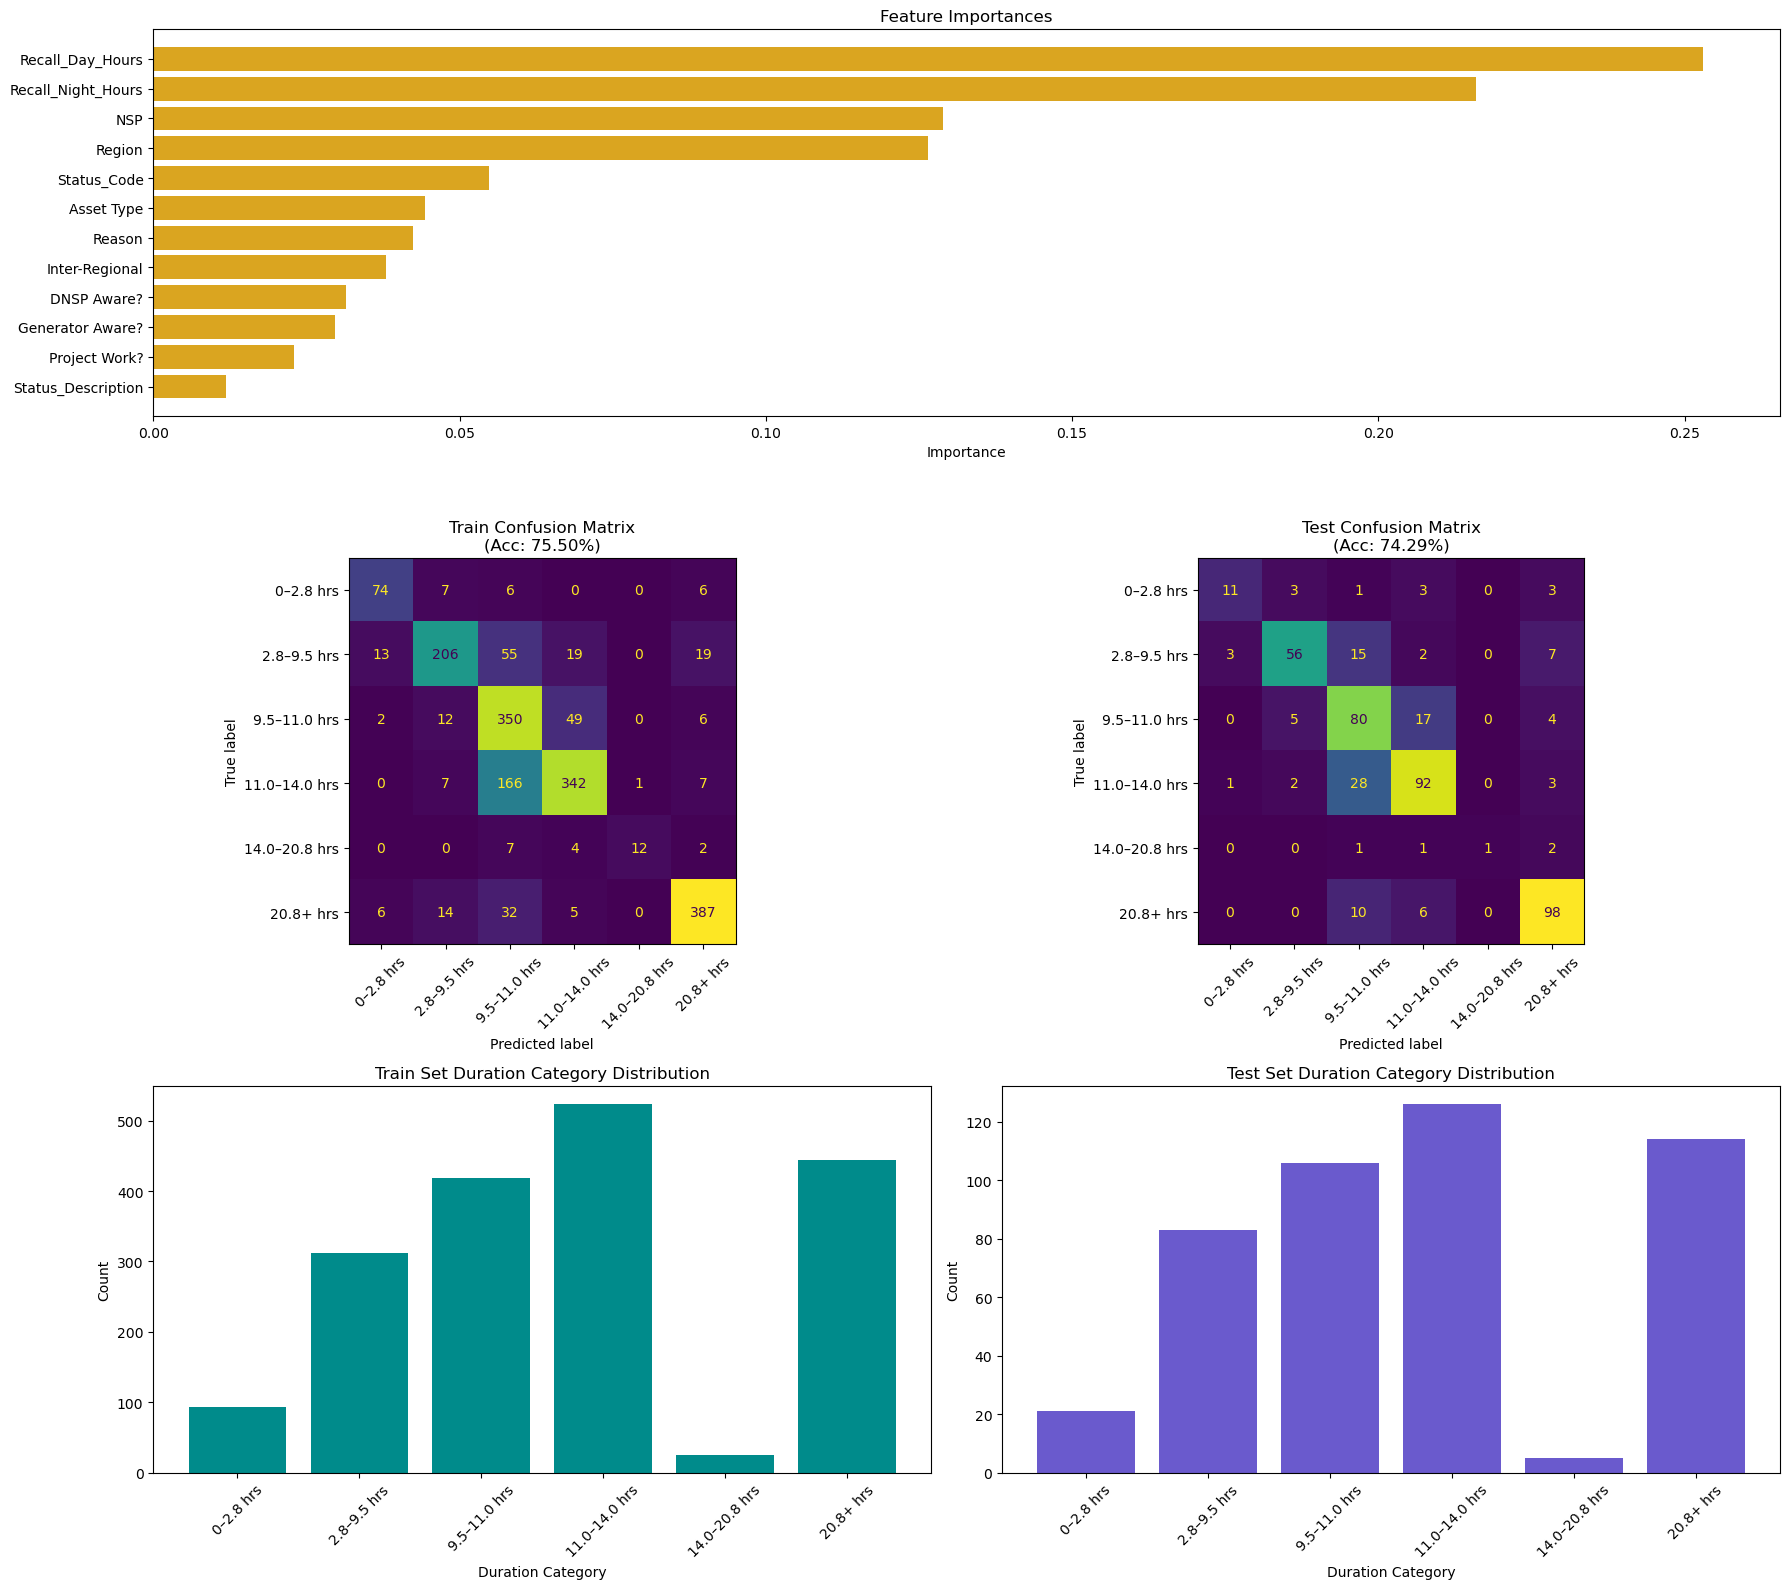

In [9]:
model = train_and_evaluate_rf(df, fine_tune=True)

### Model fitting on state-specific data

--- Region: SA ---
Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       1.00      1.00      1.00         3
  2.8–9.5 hrs       0.60      0.75      0.67         8
 9.5–11.0 hrs       0.00      0.00      0.00         1
11.0–14.0 hrs       1.00      0.50      0.67         4
14.0–20.8 hrs       1.00      0.50      0.67         2
    20.8+ hrs       0.90      0.95      0.92        38

     accuracy                           0.86        56
    macro avg       0.75      0.62      0.65        56
 weighted avg       0.86      0.86      0.85        56



c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


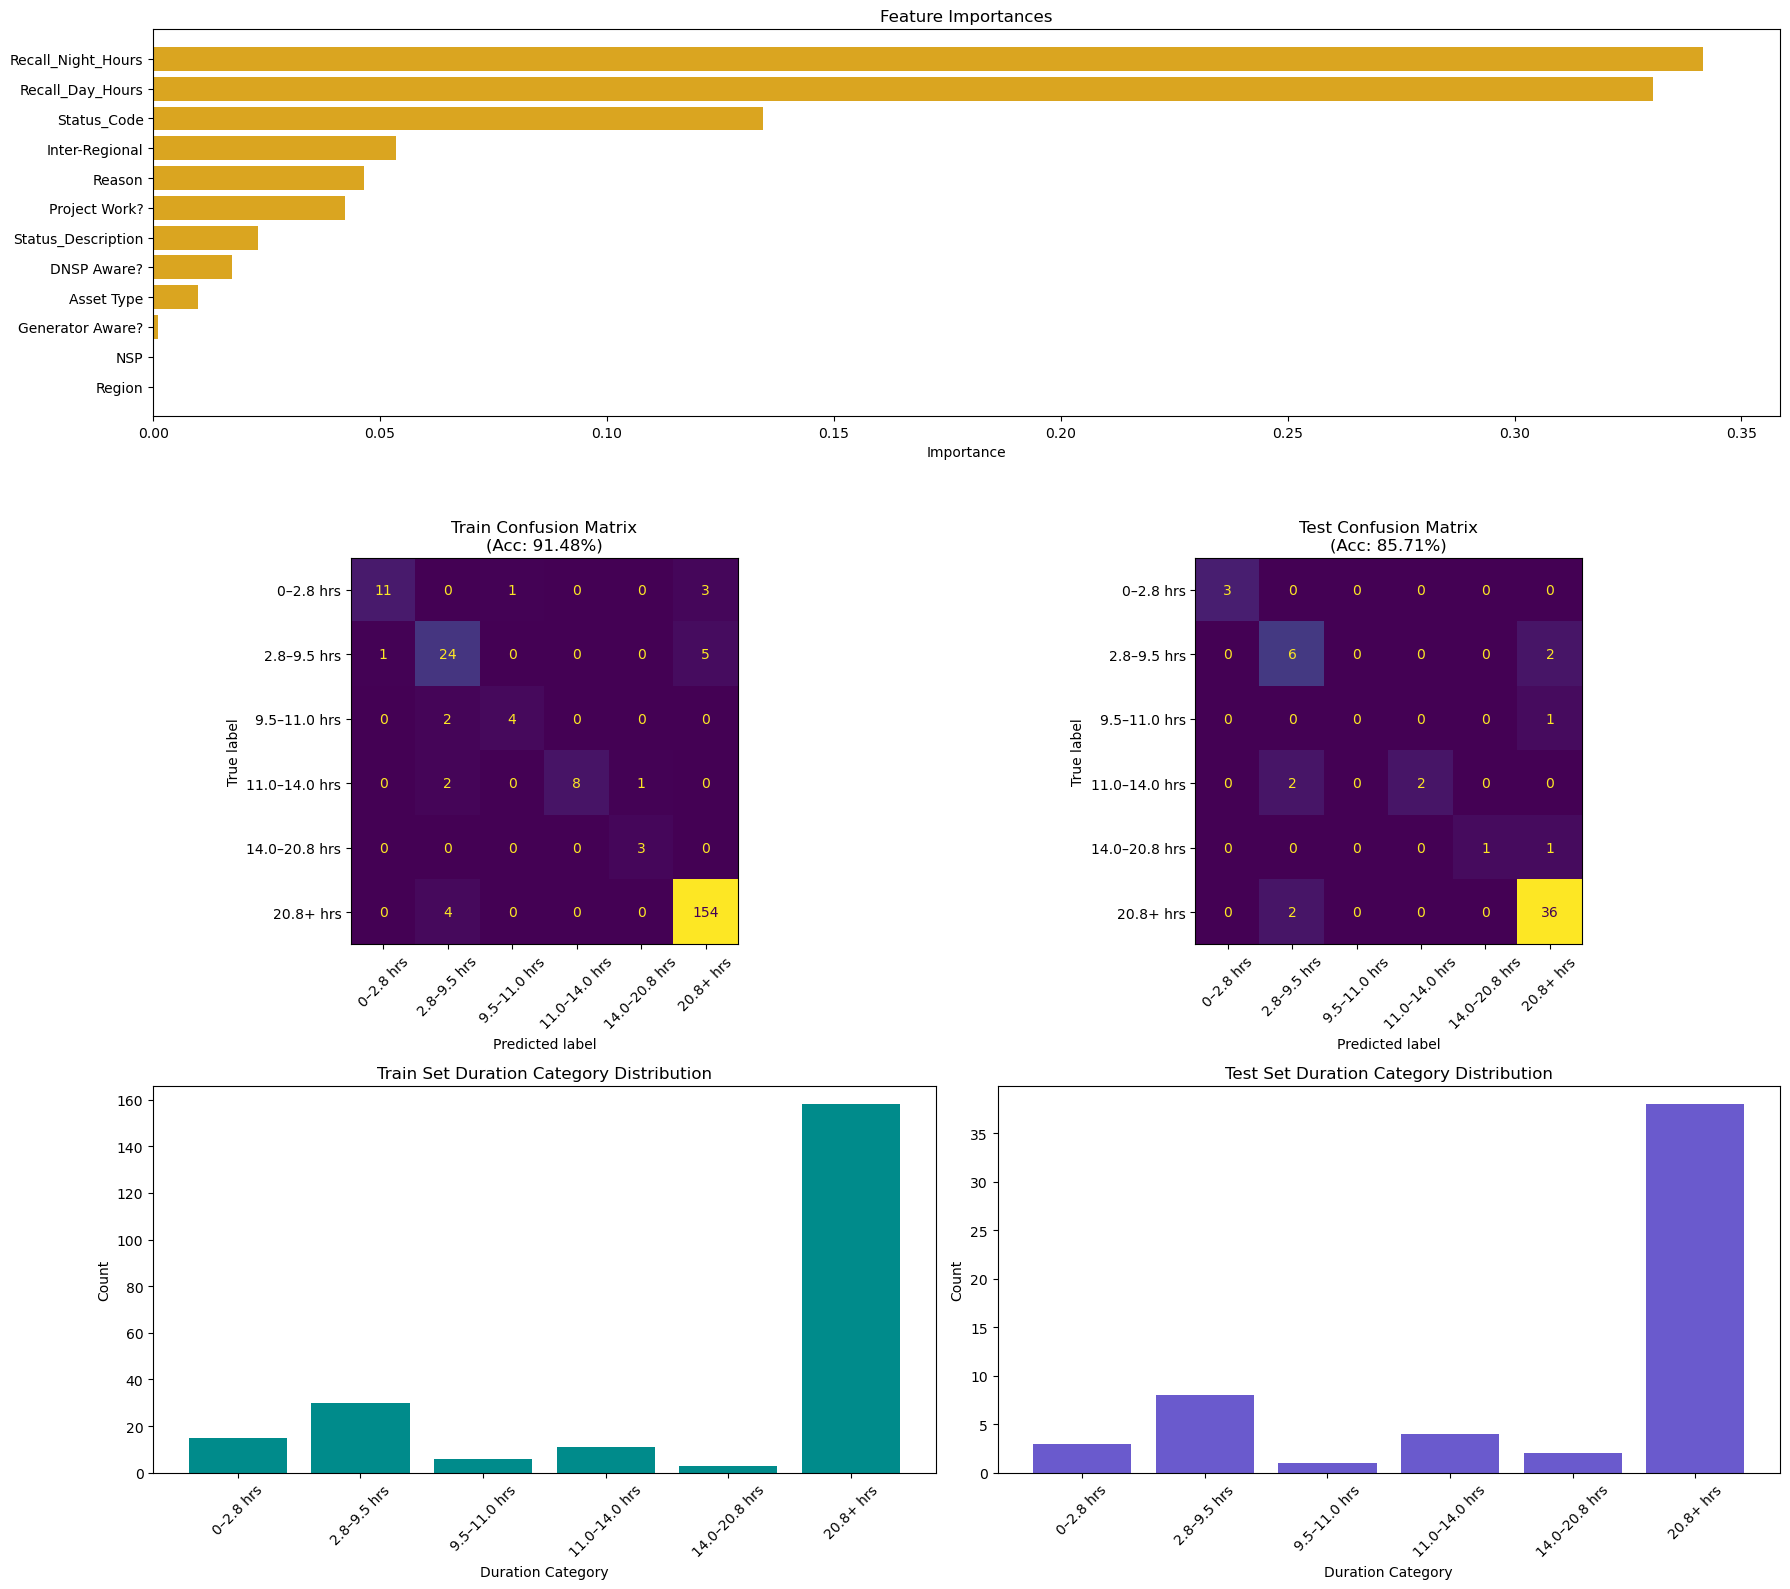

--- Region: VIC ---
Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.67      0.33      0.44         6
  2.8–9.5 hrs       0.67      0.32      0.43        19
 9.5–11.0 hrs       0.54      0.80      0.64        79
11.0–14.0 hrs       0.80      0.69      0.74       119
14.0–20.8 hrs       0.00      0.00      0.00         3
    20.8+ hrs       0.64      0.45      0.53        20

     accuracy                           0.66       246
    macro avg       0.55      0.43      0.46       246
 weighted avg       0.68      0.66      0.65       246



c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


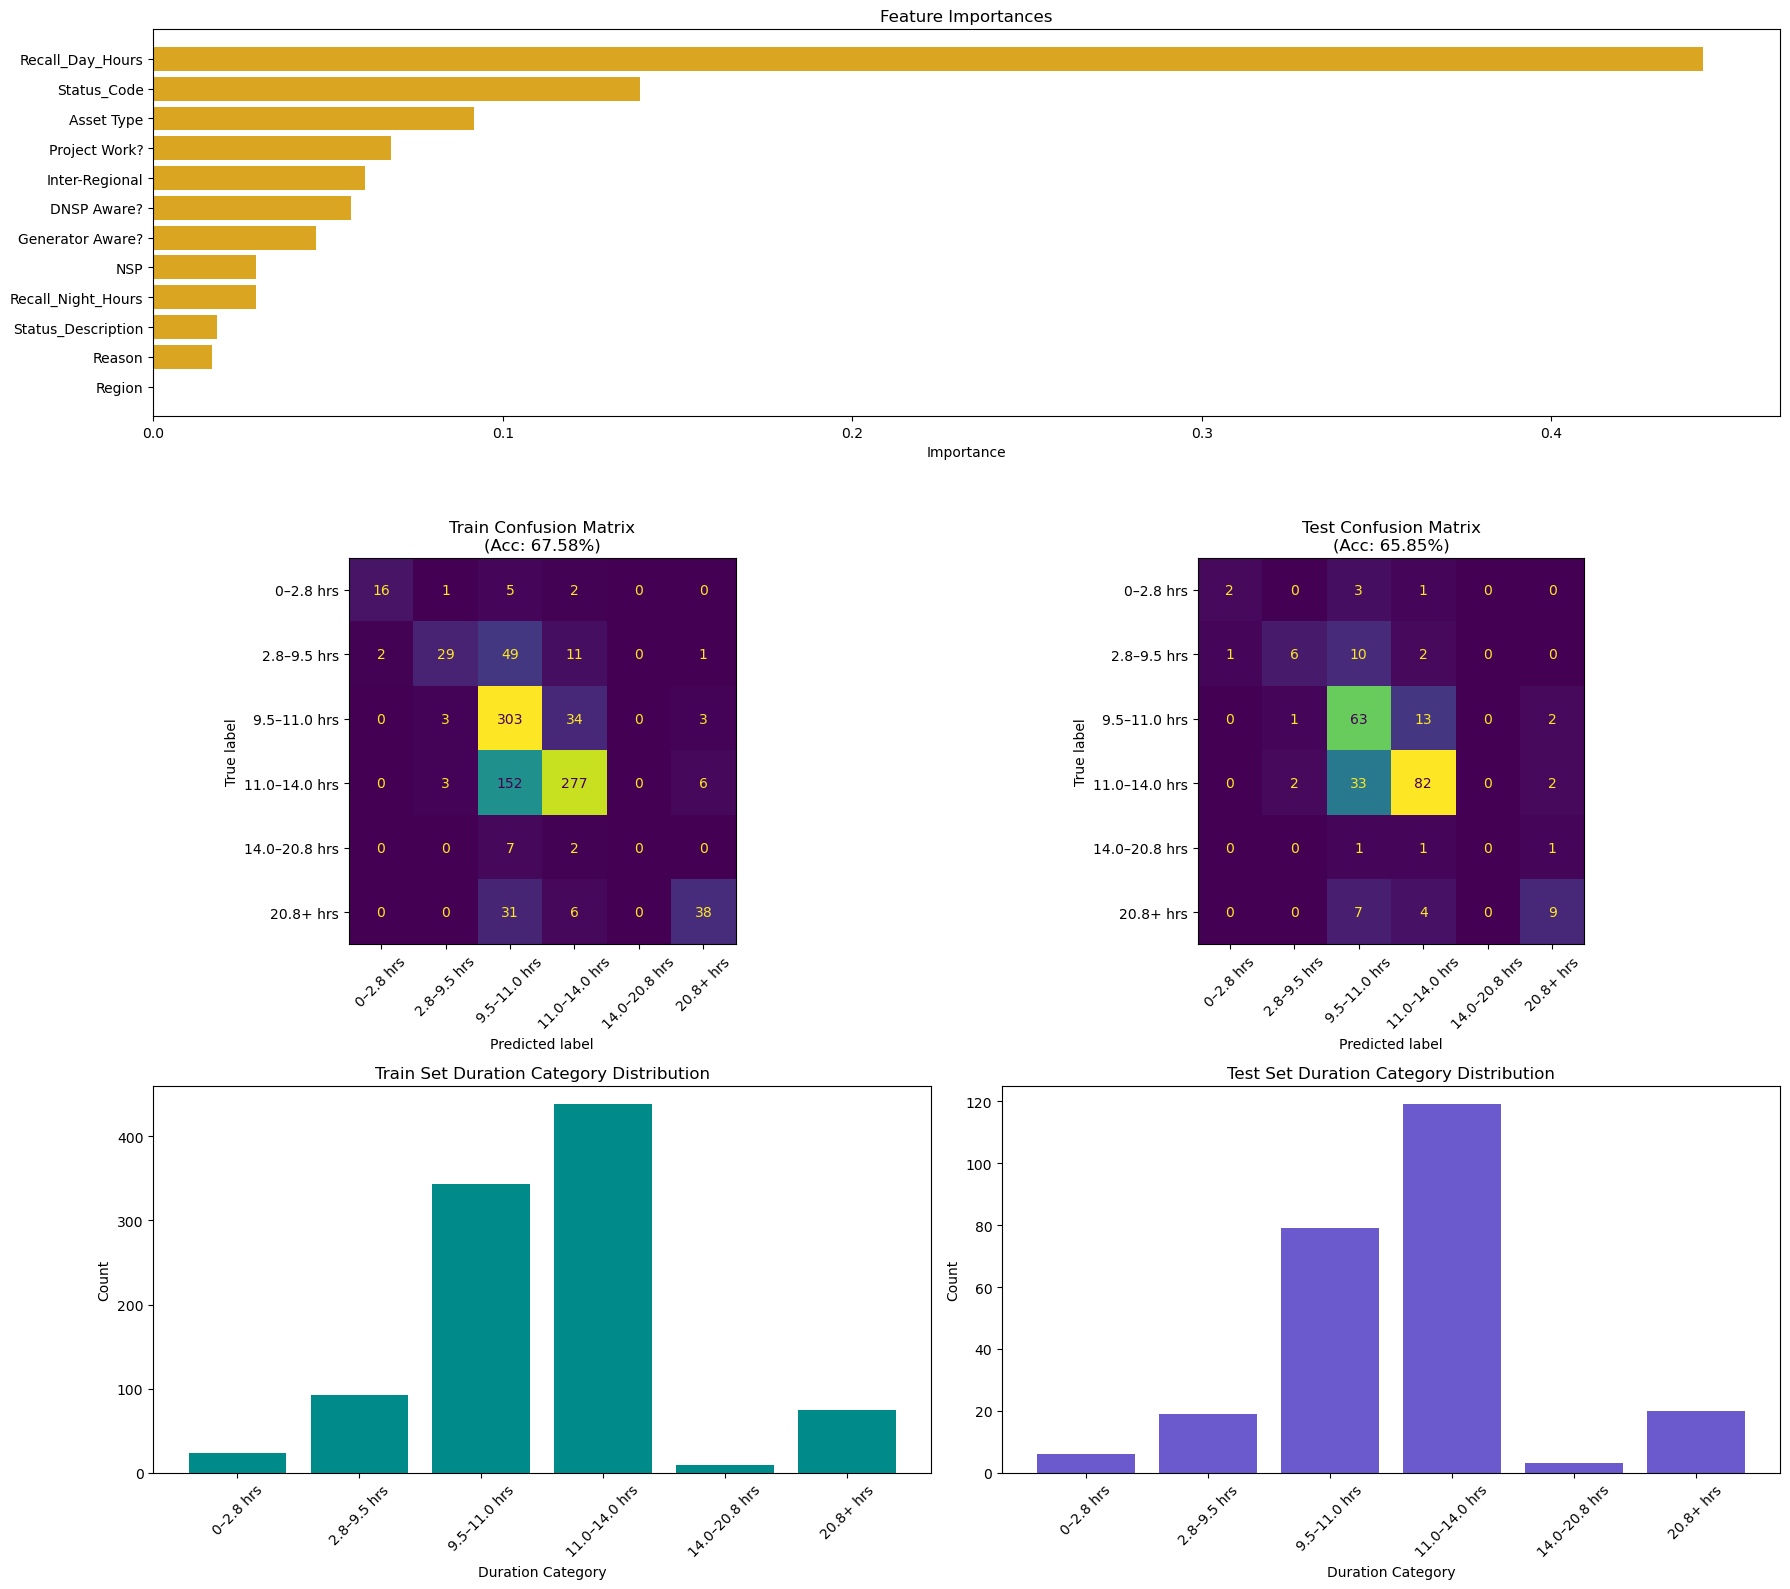

--- Region: TAS ---
Classification Report (Test Set):
              precision    recall  f1-score   support

   0–2.8 hrs       0.67      0.67      0.67         6
 2.8–9.5 hrs       0.75      0.86      0.80        14
   20.8+ hrs       0.80      0.57      0.67         7

    accuracy                           0.74        27
   macro avg       0.74      0.70      0.71        27
weighted avg       0.74      0.74      0.74        27



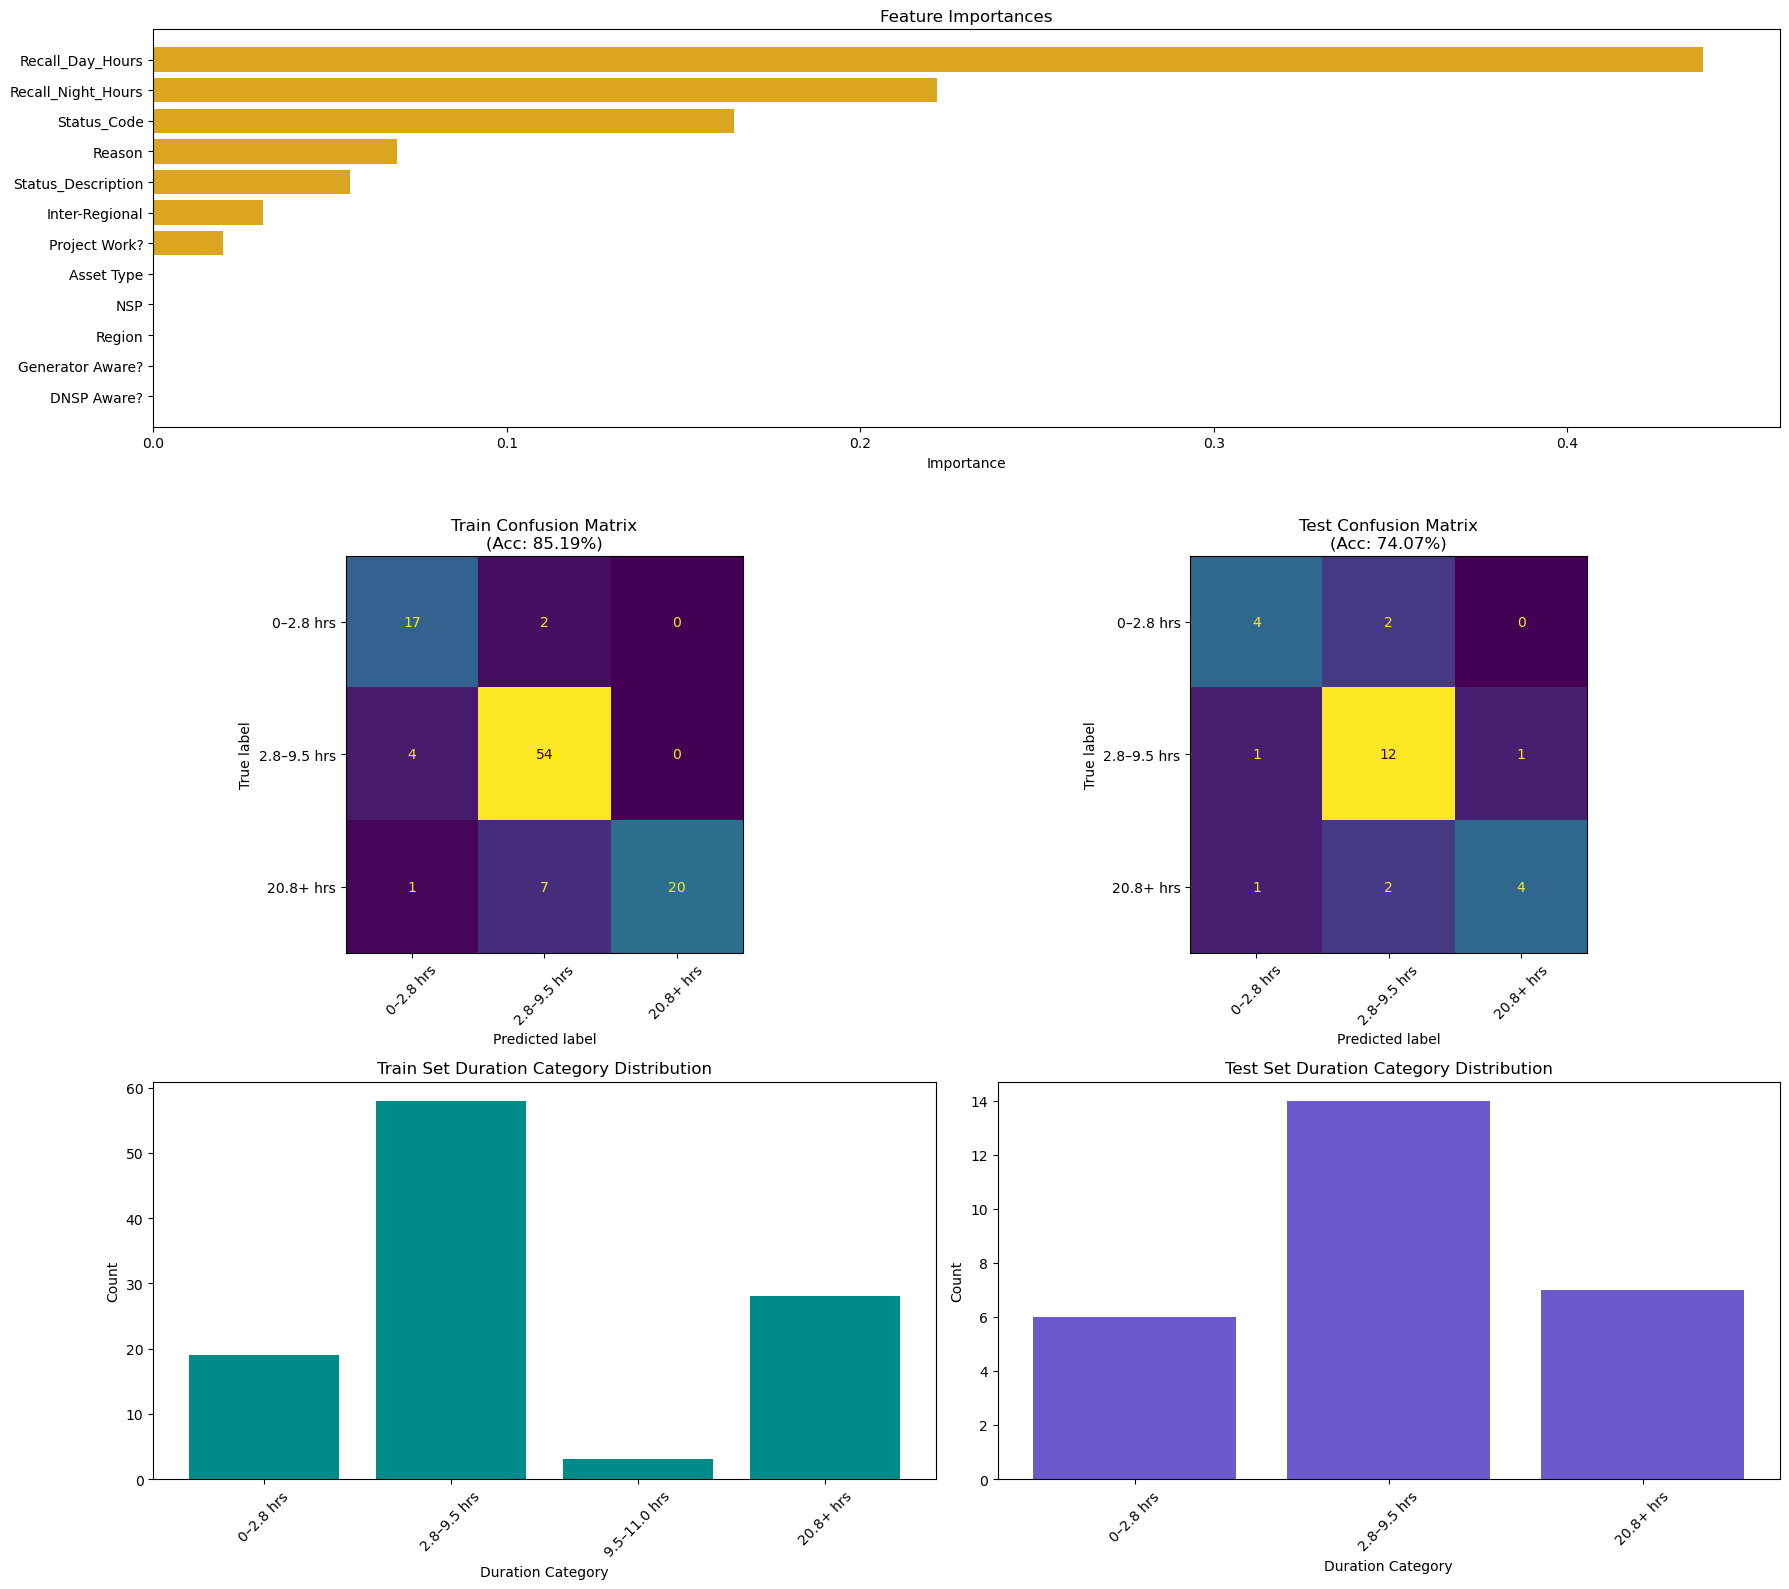

--- Region: QLD ---
Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.50      0.50      0.50         6
  2.8–9.5 hrs       0.96      0.79      0.87        34
 9.5–11.0 hrs       0.50      1.00      0.67         1
11.0–14.0 hrs       0.00      0.00      0.00         3
    20.8+ hrs       0.76      0.97      0.85        29

     accuracy                           0.81        73
    macro avg       0.54      0.65      0.58        73
 weighted avg       0.80      0.81      0.79        73



c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


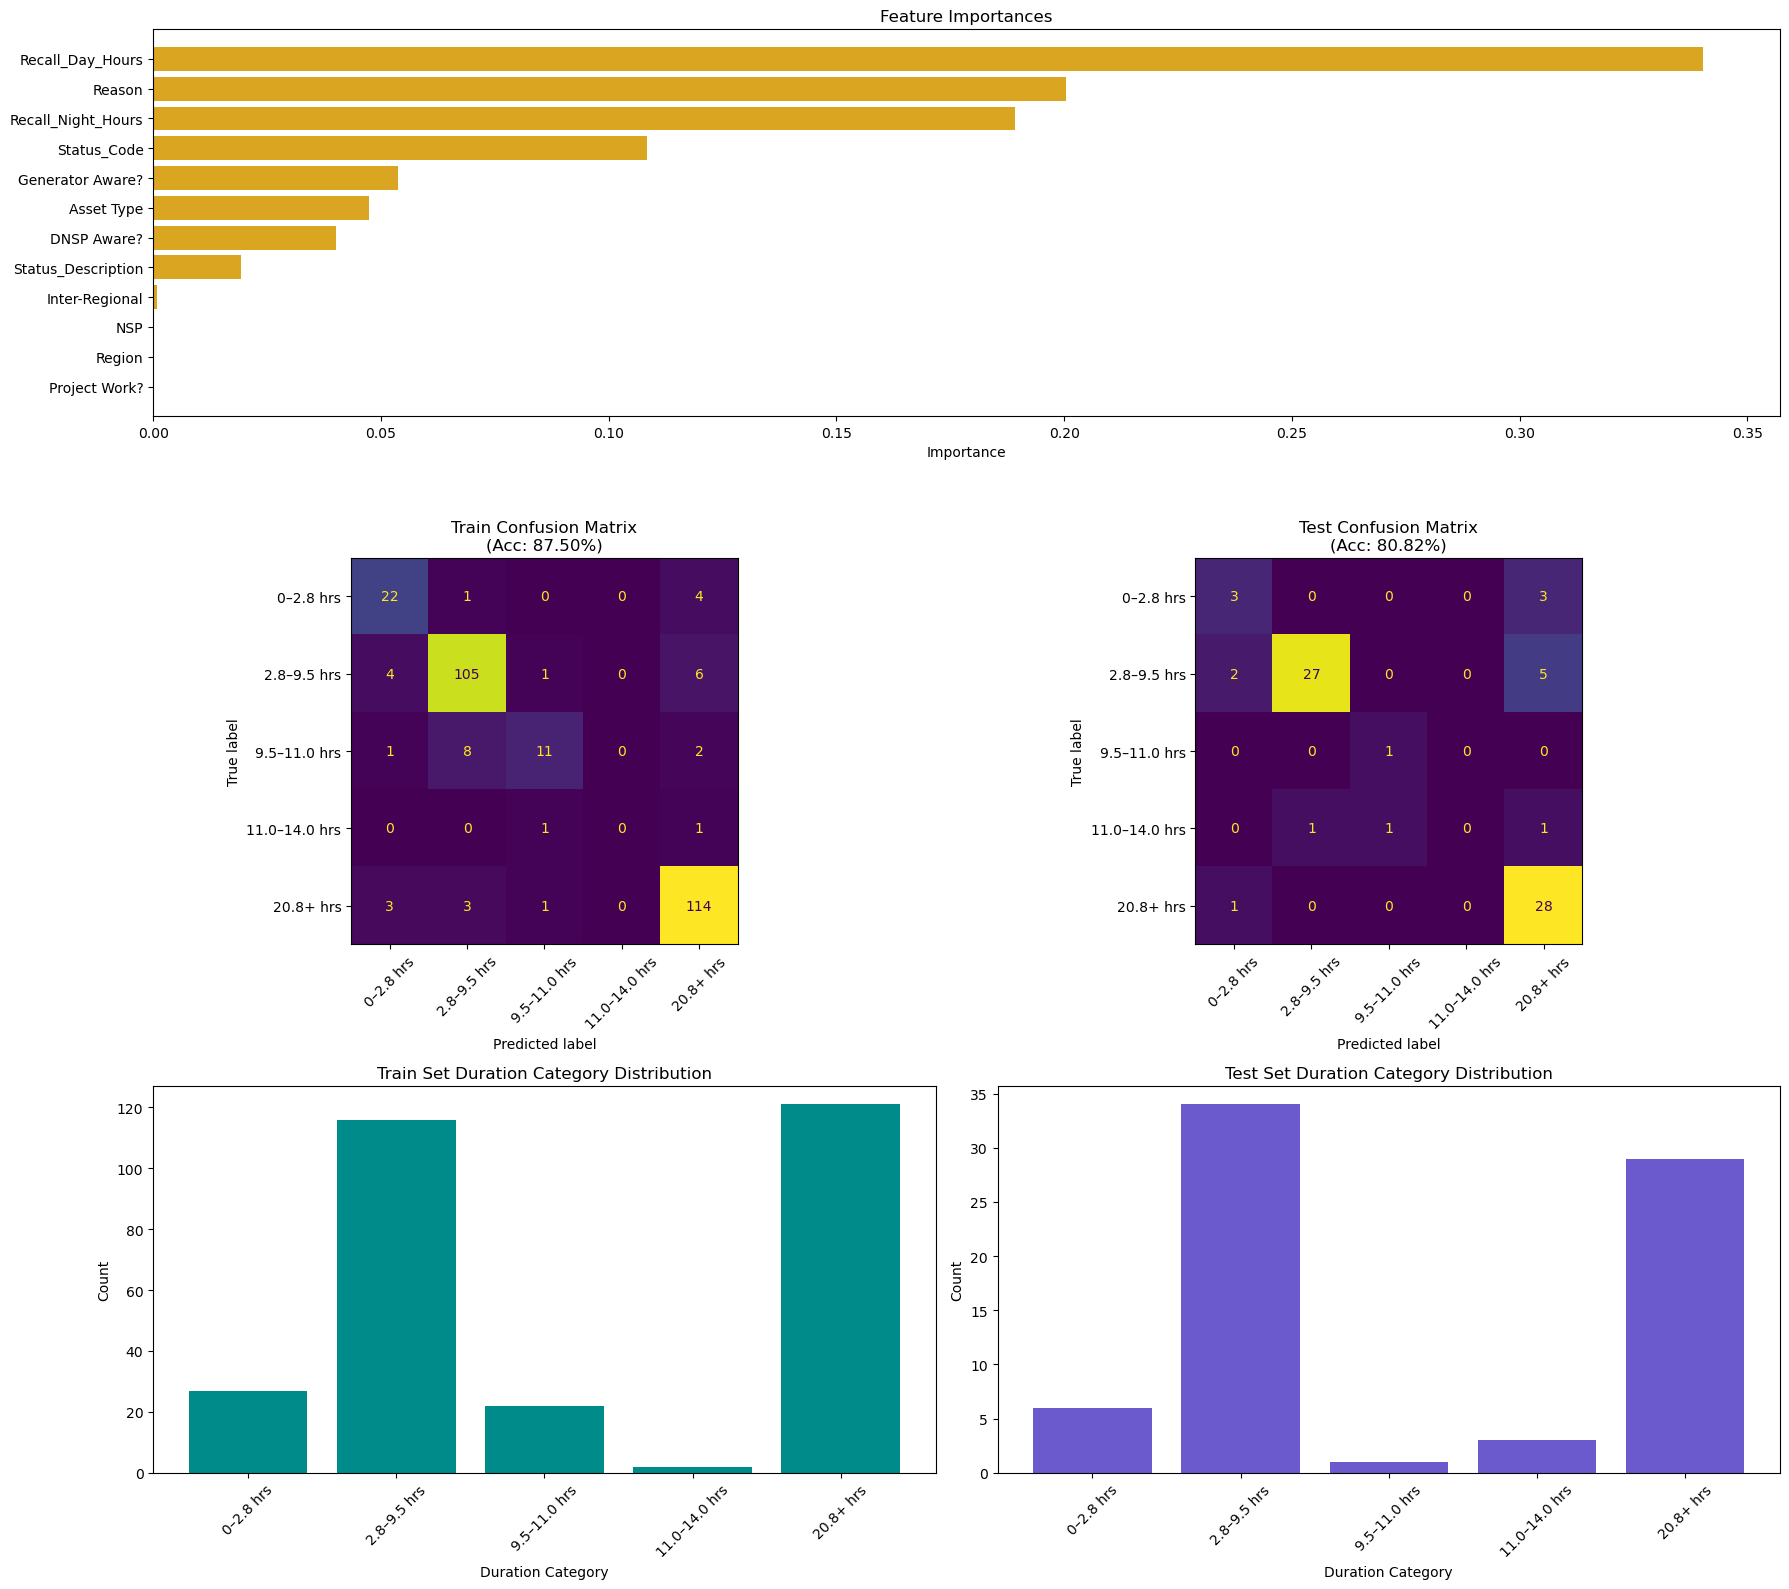

--- Region: NSW ---
Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.33      0.50      0.40         2
  2.8–9.5 hrs       0.00      0.00      0.00         5
 9.5–11.0 hrs       0.72      0.76      0.74        17
11.0–14.0 hrs       0.64      0.69      0.67        13
14.0–20.8 hrs       1.00      1.00      1.00         2
    20.8+ hrs       0.88      0.93      0.90        15

     accuracy                           0.72        54
    macro avg       0.60      0.65      0.62        54
 weighted avg       0.67      0.72      0.70        54



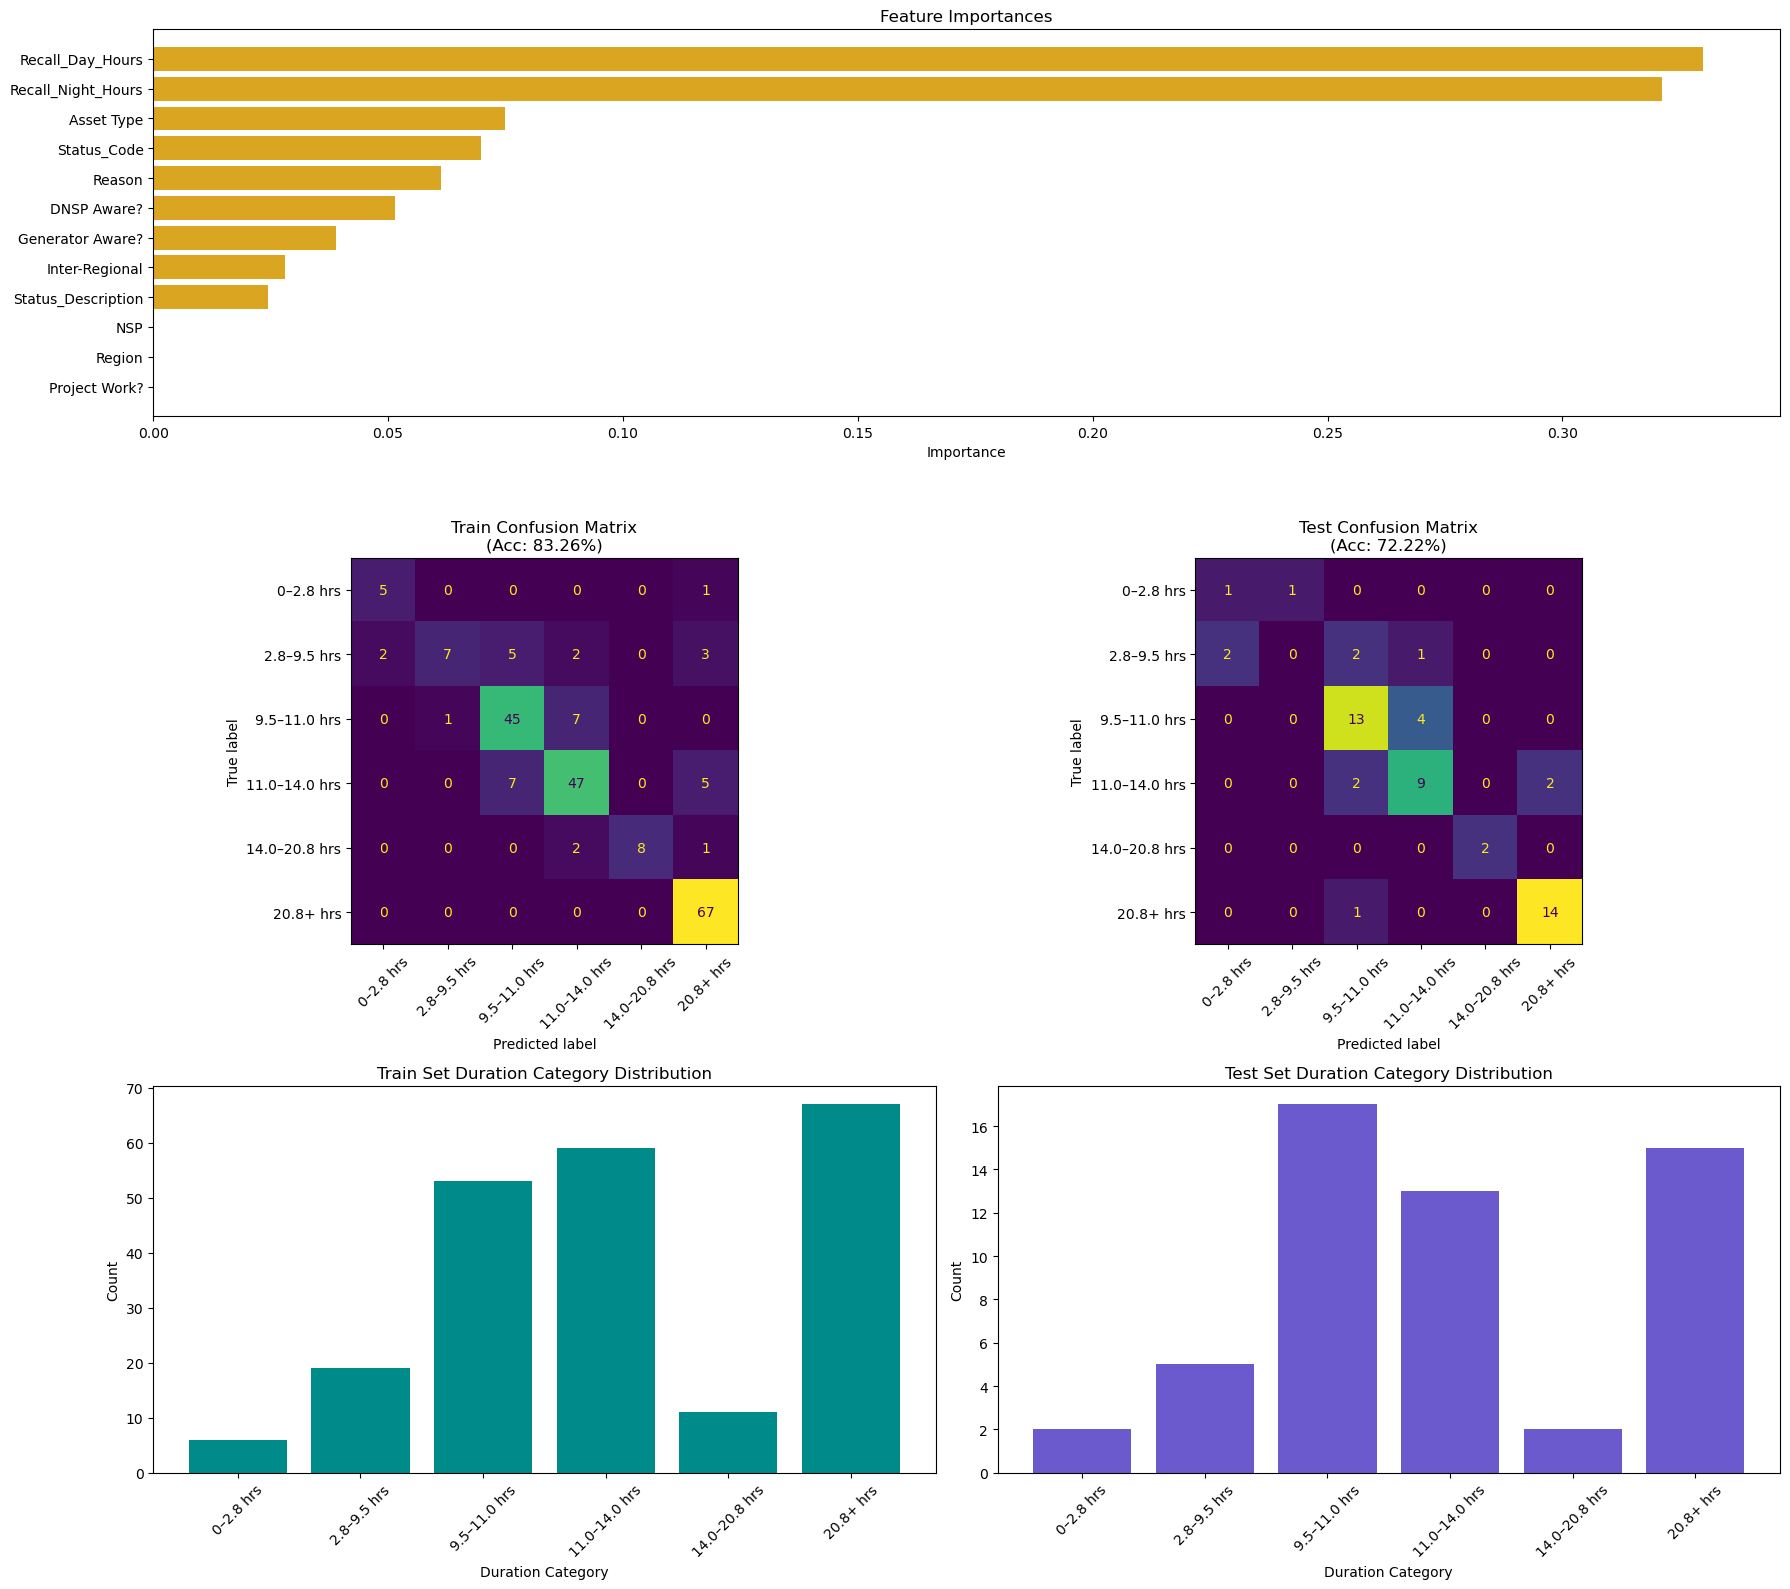

In [5]:
# Now, use the best hyperparameters to train models for each region
best_params = {
    'bootstrap': True, 
    'max_depth': 20, 
    'min_samples_leaf': 1, 
    'min_samples_split': 5, 
    'n_estimators': 150
}

region_models = {}
for region in df['Region'].unique():
    region_df = df[df['Region'] == region].copy()
    print(f"--- Region: {region} ---")
    model = train_and_evaluate_rf(region_df, fine_tune=True, best_params=best_params)
    region_models[region] = model
